# 1. Read Data

## 1.1 tif file in zip

In [1]:
from pathlib import Path
from zipfile import ZipFile
from datetime import datetime

import numpy as np
import rasterio as rio

In [2]:
sentinel2_folder = Path('data/sentinel-2')
bands =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

# use glob to get all zip file
for zip_fp in sentinel2_folder.glob('*.zip'):

    # extract data time from zip's name
    t = datetime.fromisoformat(f'{zip_fp.stem[:10]}T00:00:00Z')
    print(f'processing {t}', end='\r')

    # use ZipFile to read zip file
    with ZipFile(zip_fp) as zf:
        dict_img = dict()
        
        # get all file in zip
        for data_name in zf.namelist():

            # select band in bands
            band_name = data_name.split('L2A_')[-1].split('.')[0][:3]
            if band_name in bands:
                dict_img[band_name] = rio.open(zf.open(data_name))

    # save to tif file
    tmp = []
    for band in bands:
        rst = dict_img[band]
        tmp.append(rst.read())
    arr = np.concatenate(tmp)
    profile = rst.profile
    profile.update(
        dict(
            count=arr.shape[0],
            compress='lzw',
            dtype=rio.uint8,
        )
    )
    with rio.open(Path(f'data/tif/{t:%Y-%m-%d}.tif'), 'w', **profile) as dst:
        dst.write(arr)
        dst.descriptions = tuple(bands)

print(f'processing {t} done, all image finished')

processing 2024-04-04 00:00:00+00:00 done, all image finished


## 1.2 shapefile

In [3]:
import geopandas as gpd

In [4]:
gdf_label = gpd.read_file('data/shp/label.shp')
gdf_label.head(5)

FID                                           geometry
0    0  POLYGON ((120.375 22.88649, 120.3751 22.88647,...
1    1  POLYGON ((120.37506 22.88728, 120.3751 22.8875...
2    2  POLYGON ((120.37752 22.88846, 120.37739 22.888...
3    3  POLYGON ((120.38354 22.87697, 120.38375 22.877...
4    4  POLYGON ((120.38442 22.87725, 120.38435 22.877...

## 1.3 plot

In [5]:
import matplotlib.pyplot as plt

In [6]:
def stretch_min_max(arr, clip=[0.01,0.99]):
    arr_copy = arr.copy()
    tmp = np.sort(arr_copy.flatten())
    tmp = tmp[tmp >= 0]
    
    new_min = tmp[int(len(tmp)*clip[0])]
    if clip[1] >= 1:
        new_max = tmp[-1]
    else:
        new_max = tmp[int(len(tmp)*clip[1])]

    arr_copy[arr_copy < new_min] = new_min
    arr_copy[arr_copy > new_max] = new_max
    
    return (arr_copy - np.nanmin(arr_copy)) / (np.nanmax(arr_copy) - np.nanmin(arr_copy))

In [7]:
def plot_s2(
    tif_fp: Path,
    band_1: str = 'B04', 
    band_2: str = 'B03', 
    band_3: str = 'B02', 
    stretch_min: float=0.01, 
    stretch_max: float = 0.99
):
    rst = rio.open(tif_fp)
    rst_bands = list(rst.descriptions)

    arr = stretch_min_max(
        rst.read([
            rst_bands.index(band_1)+1, 
            rst_bands.index(band_2)+1, 
            rst_bands.index(band_3)+1
        ]), 
        clip=[stretch_min, stretch_max]
    )
    left, bottom, right, top = rst.bounds
    
    fig, ax = plt.subplots(1,1,dpi=150)
    gdf_label.to_crs(4326).plot(ax=ax, color='red')
    ax.imshow(arr.transpose([1,2,0]), extent=[left, right, bottom, top])
    ax.set_xlabel('Longitude (wgs84)')
    ax.set_ylabel('Latitude (wgs84)')
    ax.set_title(tif_fp.stem)
    plt.show()

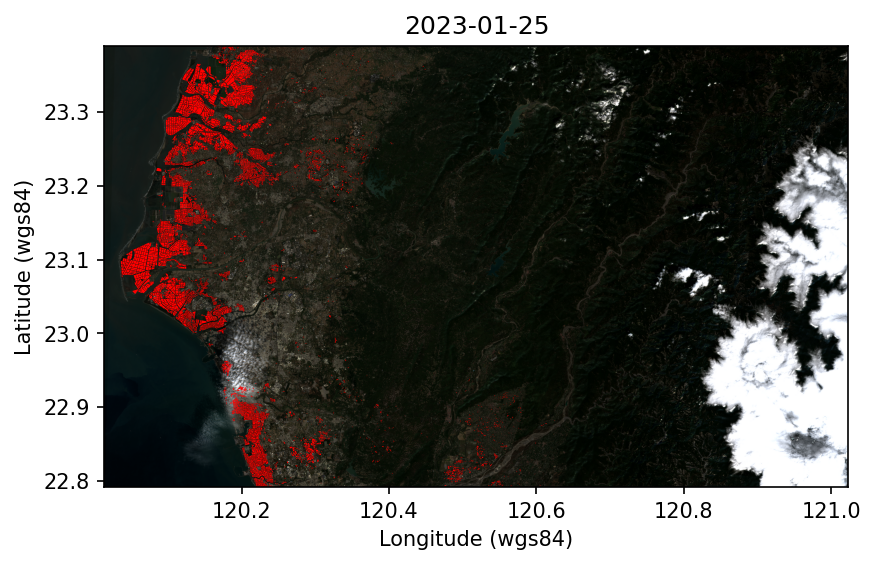

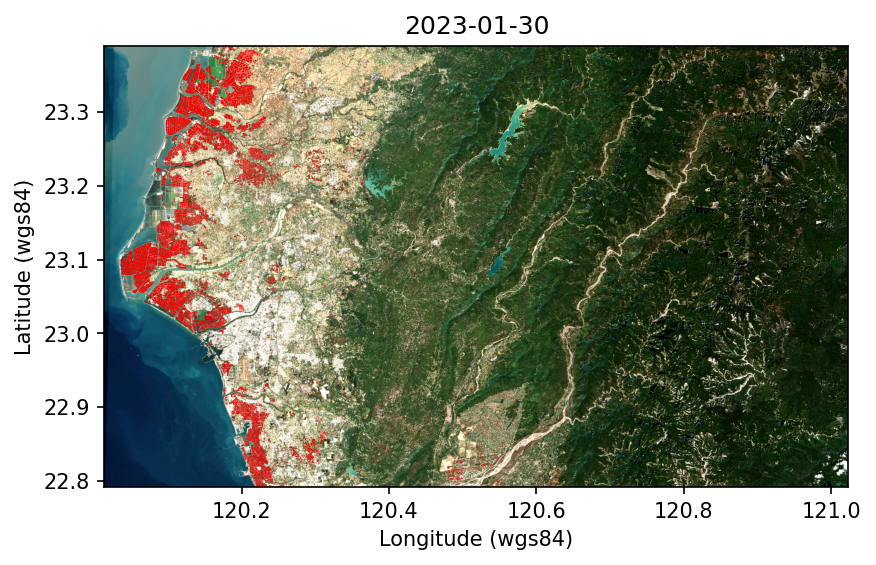

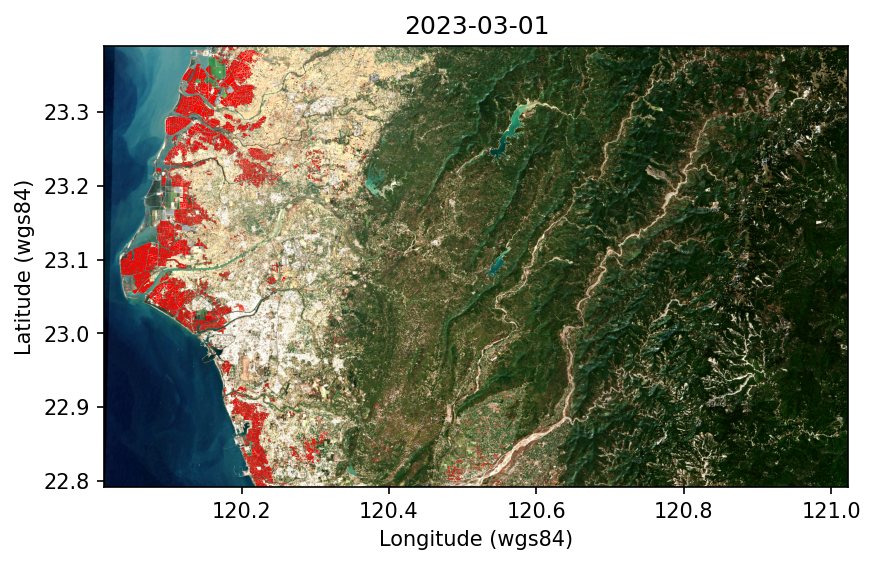

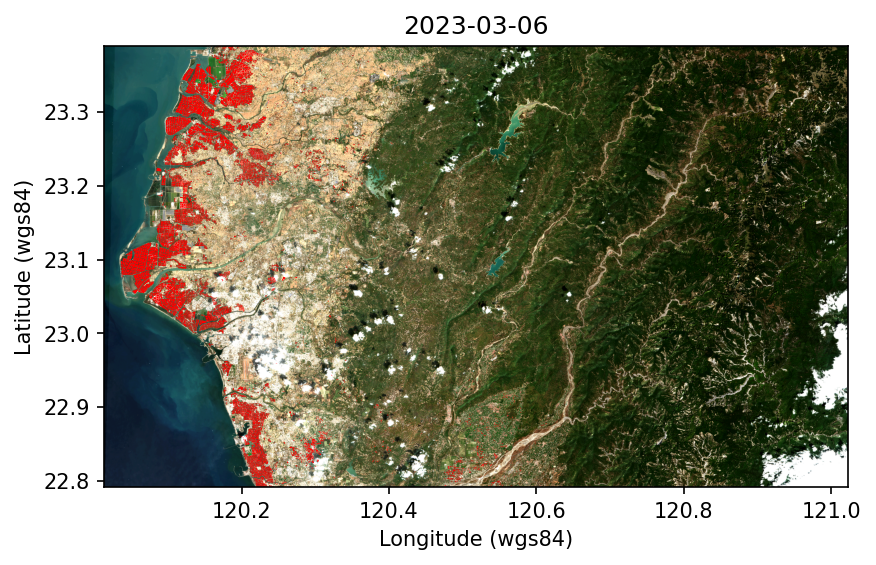

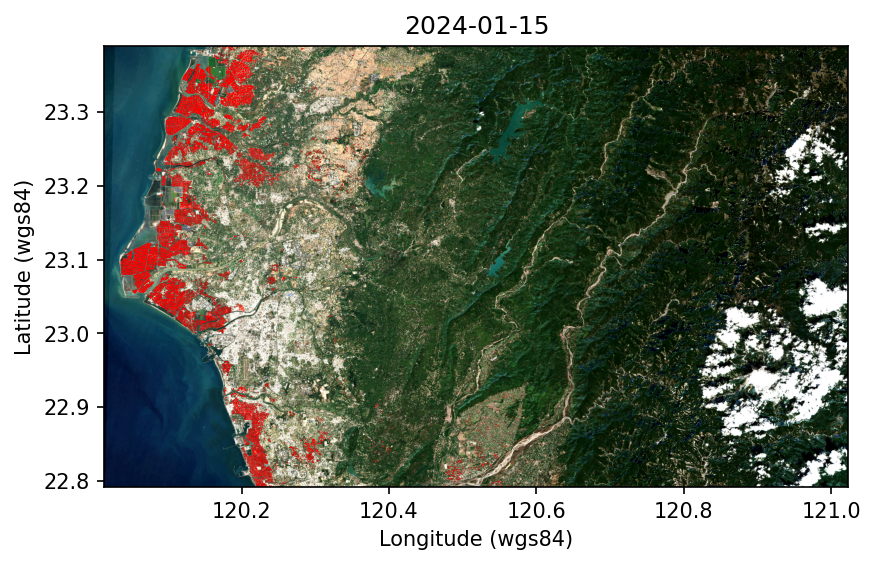

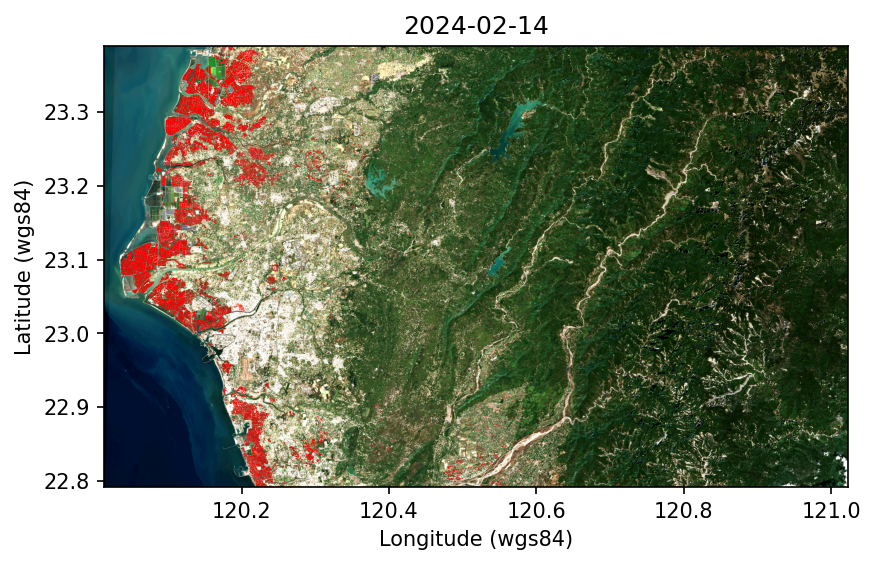

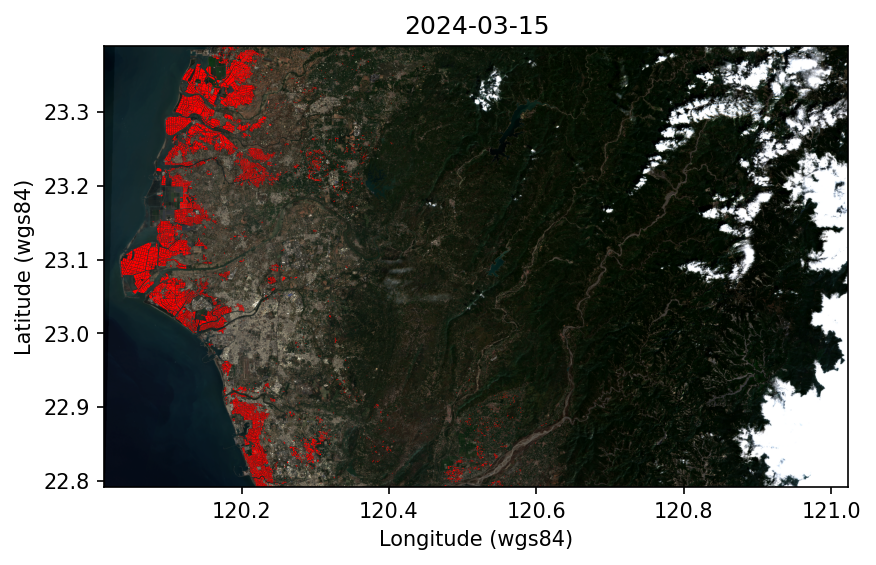

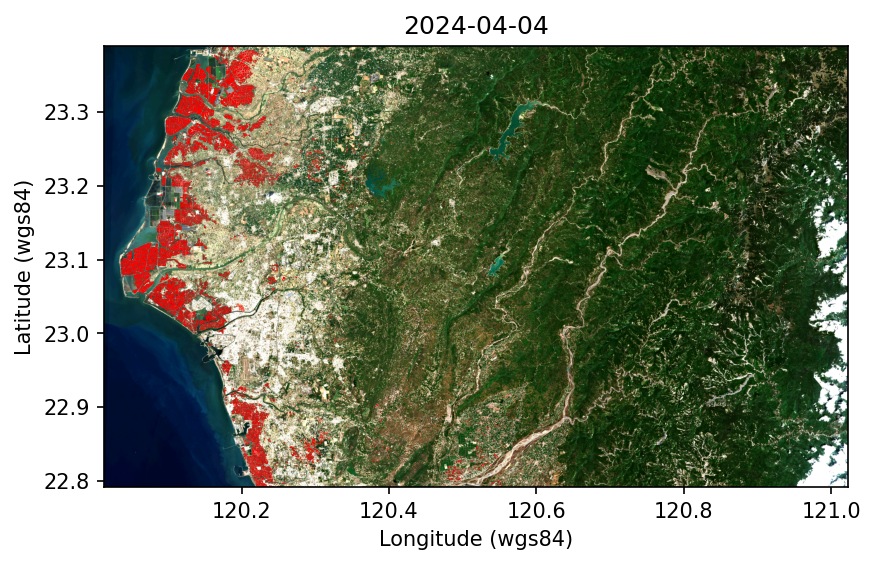

In [8]:
for tif_fp in Path('data/tif').glob('*tif'):
    plot_s2(tif_fp, stretch_min=0.05, stretch_max=0.95)

# 2. Preprocessing

## 2.1 find pixels that overlap with shapefile

In [9]:
import rasterio.mask as rmask

In [10]:
datasets = dict(label_true = [], label_false = [])

for tif_fp in Path('data/tif').glob('2023*tif'):
    print(f'preprocessing {tif_fp.stem}', end='\r')
    rst = rio.open(tif_fp)
    arr = rst.read()
    mask, gt = rmask.mask(rst, gdf_label.to_crs(rst.crs.to_epsg())['geometry'].values, all_touched=True)
    datasets['label_true'].append(stretch_min_max(arr)[:, mask[0] > 0].T)
    datasets['label_false'].append(stretch_min_max(arr)[:, mask[0] <= 0].T)

print(f'preprocessing {tif_fp.stem} done, all image finished')

preprocessing 2023-03-06 done, all image finished


## 2.2 create dataframe from datasets

In [11]:
import pandas as pd

In [12]:
df_true = pd.DataFrame(np.vstack(datasets['label_true']))
df_true['target'] = 1

df_false = pd.DataFrame(np.vstack(datasets['label_false']))
df_false['target'] = 0

df = pd.concat([df_true, df_false.sample(len(df_true))]).reset_index(drop=True)
df.columns = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'target']
print(len(df))
df.head(5)

1374488


B01       B02       B03       B04       B05       B06       B07  \
0  0.061728  0.053498  0.069959  0.086420  0.123457  0.164609  0.181070   
1  0.049383  0.049383  0.061728  0.074074  0.115226  0.168724  0.193416   
2  0.049383  0.045267  0.061728  0.065844  0.102881  0.185185  0.205761   
3  0.049383  0.049383  0.065844  0.069959  0.102881  0.164609  0.185185   
4  0.045267  0.041152  0.057613  0.065844  0.086420  0.123457  0.139918   

        B08       B8A       B09       B11       B12  target  
0  0.189300  0.209877  0.172840  0.222222  0.156379       1  
1  0.209877  0.226337  0.176955  0.205761  0.127572       1  
2  0.234568  0.234568  0.201646  0.176955  0.111111       1  
3  0.209877  0.213992  0.193416  0.181070  0.115226       1  
4  0.172840  0.160494  0.172840  0.156379  0.094650       1

In [13]:
# df.to_csv('data/datasets.csv', index=False)

## 2.3 split to train set and test set

In [14]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1], test_size=0.2, random_state=2024, shuffle=True)

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# 3. Training

In [34]:
params = {
    "objective": "binary",
    "metric": ["binary_error","l1","l2"],
    'boosting_type': 'gbdt',         # Gradient Boosting Decision Trees
    'num_leaves': 31,                # Maximum number of leaves in one tree
    'learning_rate': 1e-6,           # Learning rate
    'feature_fraction': 0.9,         # Randomly select a fraction of features for training each tree
}

callbacks = [
    lgb.log_evaluation(period=10), 
    # lgb.early_stopping(stopping_rounds=30)
]

In [35]:
bst = lgb.train(
    params, 
    train_data, 
    # valid_sets=[train_data, val_data], 
    num_boost_round=1000,
    callbacks=callbacks
)

[LightGBM] [Info] Number of positive: 549421, number of negative: 550169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 1099590, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499660 -> initscore=-0.001361
[LightGBM] [Info] Start training from score -0.001361


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

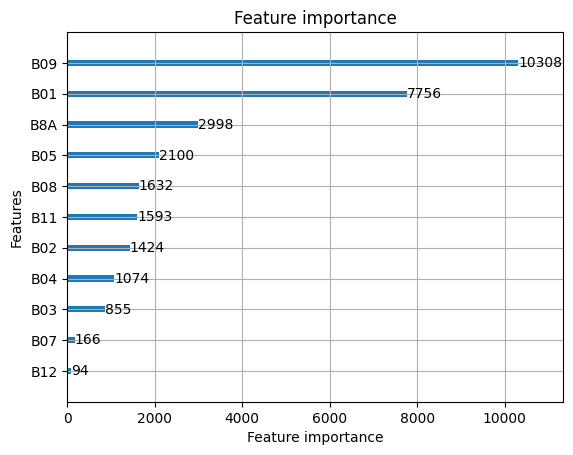

In [36]:
lgb.plot_importance(bst, max_num_features=12)

# 4. Test and Predict

In [73]:
rst.shape

(1610, 2500)

In [72]:
arr[:, mask[0] > 0].shape

(12, 171810)

In [76]:
rst = rio.open('data/tif/2024-02-14.tif')
h, w = rst.shape
arr = rst.read().reshape(12, h*w).T
# arr
# mask, gt = rmask.mask(rst, gdf_label.to_crs(rst.crs.to_epsg())['geometry'].values, all_touched=True)

# df_t = pd.DataFrame(stretch_min_max(arr)[:, mask[0] > 0].T)
# df_t['ground'] = 1
# df_f = pd.DataFrame(stretch_min_max(arr)[:, mask[0] <= 0].T)
# df_f['ground'] = 0
# df = pd.concat([df_t, df_f]).reset_index(drop=True)
# df.columns = bands + ['ground']
# df

In [109]:
prob = bst.predict(arr)
predict = [1 if p > 0.4993 else 0 for p in prob]

In [111]:
im_pred = np.array(predict).reshape(h, w)

In [83]:
# Total = len(df)
# TP = len(df[(df['predict'] == 1)&(df['ground'] == 1)]) / Total
# TN = len(df[(df['predict'] == 0)&(df['ground'] == 0)]) / Total
# FP = len(df[(df['predict'] == 1)&(df['ground'] == 0)]) / Total
# FN = len(df[(df['predict'] == 0)&(df['ground'] == 1)]) / Total
# print(f'TP={TP*100:.2f}%, TN={TN*100:.2f}%, FP={FP*100:.2f}%, FN={FN*100:.2f}%, Acc={(TP+TN)*100:.2f}%')

In [93]:
imm = arr[:,[3,2,1]].reshape(h, w, 3)

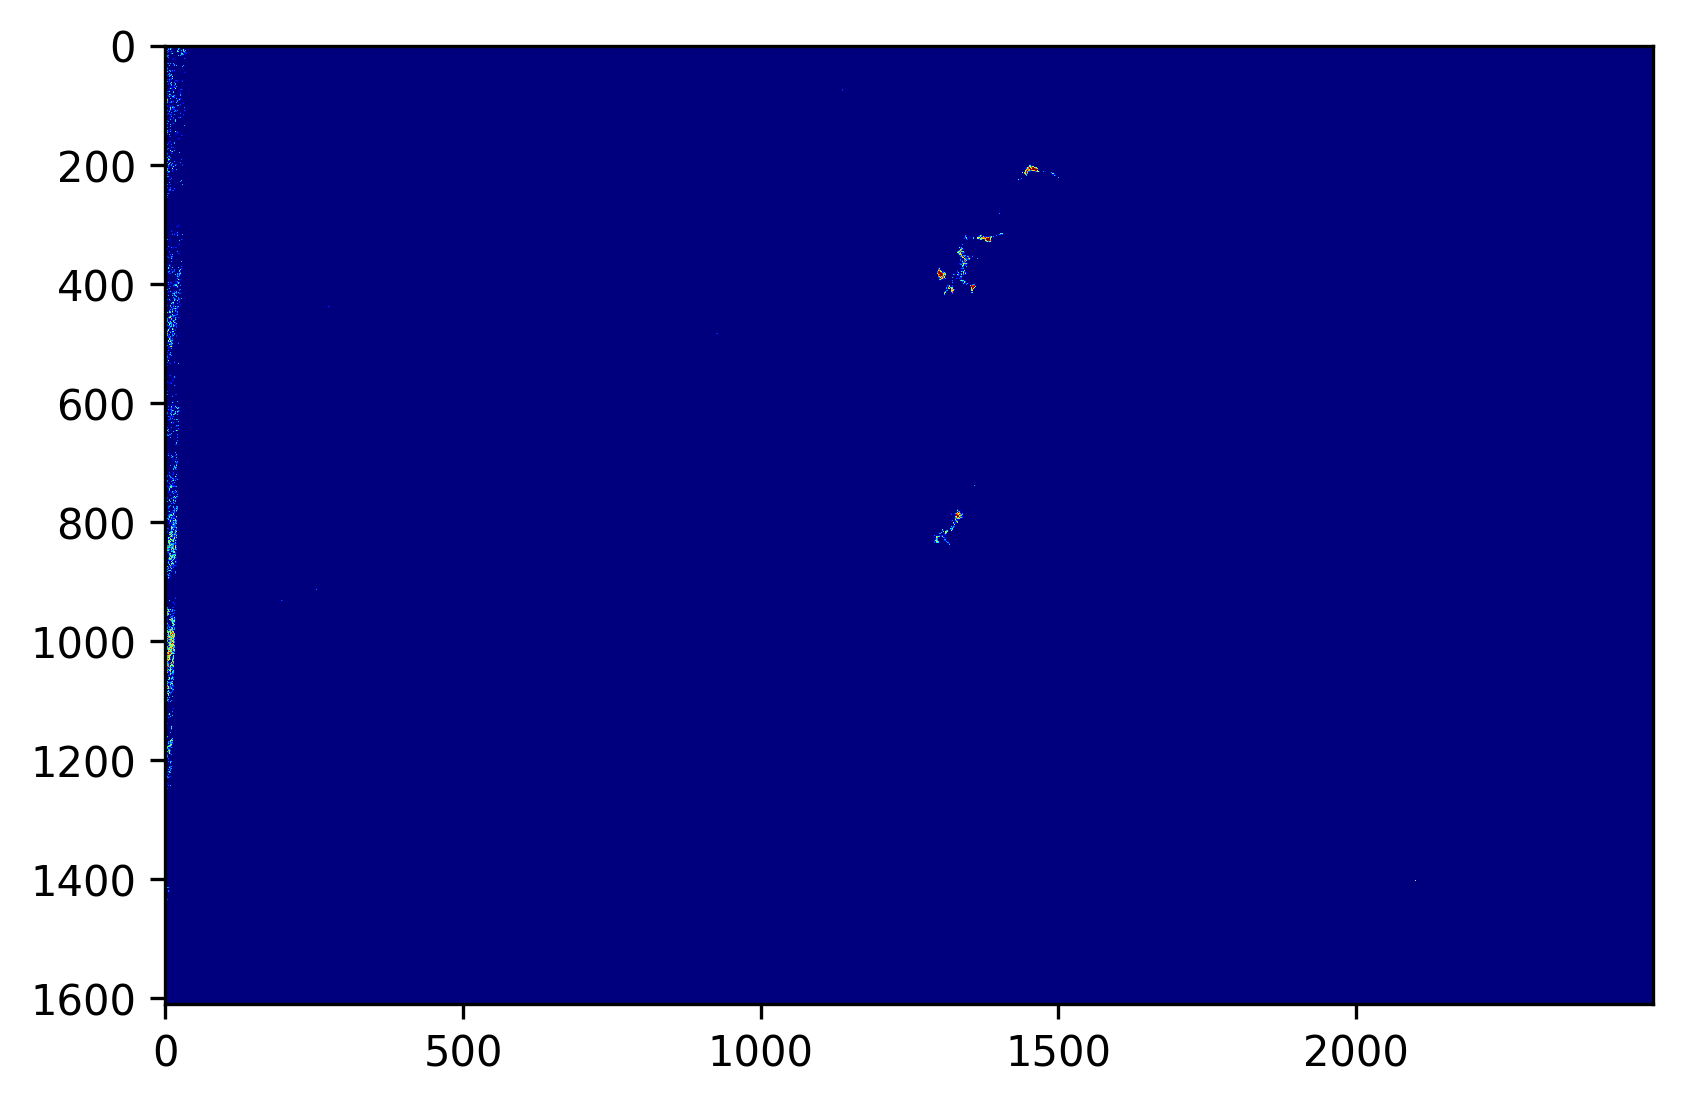

In [112]:
fig, ax = plt.subplots(1,1,dpi=300)
# h, w = rst.shape
# arr = df[['B04', 'B03', 'B02']].to_numpy()#.reshape([w, h, 3])
# tmp = arr[:,0].T.reshape([1, h, w]), arr[:,1].T.reshape([1, h, w]), arr[:,2].T.reshape([1, h, w])
# im = np.concatenate(tmp)
ax.imshow(im_pred, cmap='jet')
plt.show()

